# The Importance of Combine Performance in Determining NFL Success
As a diehard fan of the Baltimore Ravens, I wish we knew which college prospects were going to become the next NFL superstars. This desire to predict the future is common among all NFL coaching staffs, players, and other fans alike. Franchises spend millions of dollars on scouting every year, yet there are always "busts" that seemingly could have never been predicted. How do some of the best scouts that money can buy somehow seem to mess up so frequently? 

One of the most important factors that NFL franchises take into account before the draft is the combine. The combine is a four day, invite only event where NFL prospects have the opportunity to demonstrate their athletic prowess by participating in various events. Participants' performance has a major impact on how both the media and scouts view them. Players can be taken much higher than expected or simply get a team to notice them based exclusively on their combine performance. Disregarding how NFL franchises interpret the draft, I want to examine the correlation between combine performance and NFL success so I can make my own opinions on future prospects.

Before beginning my exploration of this relationship, I first must gather and process data from past NFL seasons and combines. This cleaned data will then be my foundation to start conducting exploratory analysis and other testing. The first data set I'm using contains official numbers and times from the NFL combines dating back to 2000. The other data set I'm using contains NFL players' performances from the year they were drafted until 2017. My analysis will focus on defensive backs(cornerbacks and safeties) and outside linebackers. These positions are known for being physically demanding, which is ideal since the combine is supposed to represent a prospect's athletic ability.   

# Data Scraping
Sources: [Combine Scores](https://www.kaggle.com/datasets/savvastj/nfl-combine-data) and [NFL Statistics](https://www.kaggle.com/datasets/kendallgillies/nflstatistics?select=Career_Stats_Defensive.csv)

In [1]:
import pandas as pd

# Allowing access to google sheet containing data
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Opening and copying combine data into a dataframe
worksheet = gc.open('combine_data_sheet').sheet1

rows = worksheet.get_all_values()

combine_data = pd.DataFrame.from_records(rows)

# Renaming columns
combine_data.columns = ['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'Bench', 'BroadJump', 'Cone', 'Shuttle', 'Year', 'Pfr_ID', 'AV', 'Team', 'Round', 'Pick']
combine_data = combine_data.drop(labels = 0, axis = 0)

# Removing unnecessary columns
combine_data.drop(combine_data.columns[[11, 12, 13]], axis = 1, inplace = True)

# Removing undrafted players
for index, row in combine_data.iterrows():
    if(row['Round'] == ''):
        combine_data.drop(index, inplace=True)

# Isolating only defensive backs and outside linebackers
for index, row in combine_data.iterrows():
    if ((row['Pos'] ==  'CB' or row['Pos'] == 'SS' or row['Pos'] == 'FS' or row['Pos'] == 'OLB') == False) :
          combine_data.drop(index, inplace = True)

# Changing player names to all upper case
for index, row in combine_data.iterrows():
    name = row['Player']
    lc_name = row['Player'].upper()
    combine_data['Player'] = combine_data['Player'].replace([name], lc_name)

    # Removing suffixes to names
    last_three = ''
    copy_name = name
    for i in range(3):
        last_three = last_three + copy_name[-1]
        copy_name = copy_name[:-1]

    last_three = last_three[::-1]

    if last_three == '-02' or last_three == '-03' or last_three == '-04':
        new_name = row['Player']
        new_name = new_name[:-1]
        new_name = new_name[:-1]
        new_name = new_name[:-1]
        combine_data['Player'] = combine_data['Player'].replace([lc_name], new_name)


combine_data.reset_index(inplace = True)

combine_data

,index,Player,Pos,Ht,Wt,Forty,Vertical,Bench,BroadJump,Cone,Shuttle,Year,Round,Pick
0,1,JOHN ABRAHAM,OLB,76,252,4.55,,,,,,2000,1,13
1,5,RASHARD ANDERSON,CB,74,206,4.55,34,,123,7.18,4.15,2000,1,23
2,7,LAVAR ARRINGTON,OLB,75,250,4.53,,,,,,2000,1,2
3,10,REGGIE AUSTIN,CB,69,175,4.44,35,17,119,7.03,4.14,2000,4,125
4,13,RASHIDI BARNES,FS,72,208,4.62,35,10,114,6.92,4.32,2000,7,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,5870,TIM WILLIAMS,OLB,75,244,4.68,33.5,,124,7.36,4.57,2017,3,78
1011,5877,QUINCY WILSON,CB,73,211,4.54,32,14,118,6.86,4.02,2017,2,46
1012,5879,HOWARD WILSON,CB,73,184,4.57,33.5,,119,6.68,3.94,2017,4,126
1013,5880,AHKELLO WITHERSPOON,CB,75,198,4.45,40.5,,127,6.93,4.13,2017,3,66


The current state of this data is a complete disaster. There are missing cells, unnecessary columns, and far too many entries. Cleaning the data will make it easier to interpret and manipulate later on.

In [2]:
# Setting each empty data point to 0
for index, row in combine_data.iterrows():
    combine_data['Forty'] = combine_data['Forty'].replace([''], '0')
    combine_data['Vertical'] = combine_data['Vertical'].replace([''],'0')
    combine_data['Bench'] = combine_data['Bench'].replace([''],'0')
    combine_data['BroadJump'] = combine_data['BroadJump'].replace([''],'0')
    combine_data['Cone'] = combine_data['Cone'].replace([''],'0')
    combine_data['Shuttle'] = combine_data['Shuttle'].replace([''],'0')

# Creating seperate dataframes for each position
db_combine = pd.DataFrame(columns = ['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'Bench', 'BroadJump', 'Cone', 'Shuttle', 'Year', 'Round', 'Pick'])
olb_combine = pd.DataFrame(columns = ['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'Bench', 'BroadJump', 'Cone', 'Shuttle', 'Year', 'Round', 'Pick'])

# Isolating players drafted from 2008 to 2013
for index, row in combine_data.iterrows():
    if int(row['Year']) < 2008 or int(row['Year']) > 2013:
        combine_data.drop(index, inplace = True)

for index, row in combine_data.iterrows():
    position = row['Pos']
    if position == 'SS' or position == 'FS' or position == 'CB':
        db_combine.loc[len(db_combine.index)] = [row['Player'], position, row['Ht'], row['Wt'], row['Forty'], row['Vertical'], row['Bench'], row['BroadJump'], row['Cone'], row['Shuttle'], row['Year'], row['Round'], row['Pick']]
    else:
        olb_combine.loc[len(olb_combine.index)] = [row['Player'], position, row['Ht'], row['Wt'], row['Forty'], row['Vertical'], row['Bench'], row['BroadJump'], row['Cone'], row['Shuttle'], row['Year'], row['Round'], row['Pick']]


In [3]:
# Opening and copying player's NFL statistics into a dataframe
worksheet2 = gc.open('defensive_data').sheet1

rows2 = worksheet2.get_all_values()

defensive_data = pd.DataFrame.from_records(rows2)

# Dropping unnecessary columns and renaming
defensive_data.drop(defensive_data.columns[[0, 4, 6, 7, 10, 13, 14, 15, 16]], axis = 1, inplace = True)
defensive_data.columns = ['Player', 'Pos', 'Year', 'GamesPlayed', 'TotalTackles', 'Sacks', 'PassesDefended', 'Ints']
defensive_data = defensive_data.drop(labels = 0, axis = 0)

defensive_data

,Player,Pos,Year,GamesPlayed,TotalTackles,Sacks,PassesDefended,Ints
1,"Johnson, Quinn",,2013,4,--,--,--,--
2,"Johnson, Quinn",,2012,16,0,0,0,--
3,"Johnson, Quinn",,2011,4,--,--,--,--
4,"Johnson, Quinn",,2011,0,--,--,--,--
5,"Johnson, Quinn",,2010,11,0,0,0,--
...,...,...,...,...,...,...,...,...
23994,"Smith, Torrey",WR,2012,16,0,0,0,--
23995,"Smith, Torrey",WR,2011,16,0,0,0,--
23996,"Folsom, J.D.",,2009,2,0,0,0,--
23997,"Reader, Jamie",,2001,16,0,0,0,--


In [4]:
# Isolating only defensive backs and defensive linemen
for index, row in defensive_data.iterrows():
    if ((row['Pos'] ==  'CB' or row['Pos'] == 'SS' or row['Pos'] == 'FS' or row['Pos'] == 'OLB' or row['Pos'] == 'DB') == False) :
          defensive_data.drop(index, inplace = True)

# Dropping stats for players drafted before 2008
for index, row in defensive_data.iterrows():
    if(int(row['Year']) < 2008):
        defensive_data.drop(index, inplace = True)

# Replacing all non inputted values with 0
for index, row in defensive_data.iterrows():
    if row['GamesPlayed'] == '--':
        row['GamesPlayed'] = 0

    if row['TotalTackles'] == '--':
        row['TotaTackles'] = 0
    
    if row['Sacks'] == '--':
        row['Sacks'] = 0
    
    if row['PassesDefended'] == '--':
        row['PassesDefended'] = 0
    
    if row['Ints'] == '--':
        row['Ints'] = 0

defensive_data.reset_index(inplace = True)

In [5]:
# Replacing the player column with names in first name last name format instead
for index, row in defensive_data.iterrows():
    name = row['Player']
    last, first = name.split(', ')
    formatted_name = (first + ' ' + last).upper()
    defensive_data['Player'] = defensive_data['Player'].replace([name], formatted_name)

# Dropping stats for players without combine testing scores
player_names = combine_data['Player']

def has_combine_data(name):
    for index, row in combine_data.iterrows():
        if name == row['Player']:
            return True
    return False

for index, row in defensive_data.iterrows():
    if has_combine_data(row['Player']) == False:
          defensive_data.drop(index, inplace = True)

In [6]:
# Adding up total stats and used rows

copy = pd.DataFrame(columns = ['Player', 'Pos', 'GamesPlayed', 'TotalTackles', 'Sacks', 'PassesDefended', 'Ints'])

player_names = []

for index, row in defensive_data.iterrows():
    player = row['Player']
    pos = row['Pos']
    games = 0
    tackles = 0
    sacks = 0 
    passes_defended = 0
    int_count = 0

    if pos == 'DB':
        pos = 'CB'

    for i, r in defensive_data.iterrows():
        if player == r['Player']:
            # Summing up career statistics for each player
            if r['GamesPlayed'] != '--':
                games += int(r['GamesPlayed'])
            
            if r['TotalTackles'] != '--':
                tackles += float(r['TotalTackles'])
            
            if r['Sacks'] != '--':
                sacks += float(r['Sacks'])

            if r['PassesDefended'] != '--':
                passes_defended += int(r['PassesDefended'])

            if r['Ints'] != '--':
                int_count += int(r['Ints'])
          
    # Checking if the name has been added already
    repeat = False

    for x in range(len(player_names)):
        if player == player_names[x]:
            repeat = True

    if repeat == False:
        player_names.append(player)
        # Adding summed up data to new dataframe
        copy.loc[len(copy.index)] = [player, pos, games, tackles, sacks, passes_defended, int_count] 
copy

,Player,Pos,GamesPlayed,TotalTackles,Sacks,PassesDefended,Ints
0,KURT COLEMAN,SS,104,118.0,2.0,33,21
1,NATE ALLEN,CB,93,79.0,4.0,34,13
2,TRUMAINE JOHNSON,CB,69,38.0,0.0,53,16
3,PATRICK CHUNG,SS,109,199.0,4.0,42,9
4,TRACY PORTER,CB,98,61.0,2.5,72,13
...,...,...,...,...,...,...,...
126,DESMOND TRUFANT,CB,57,36.0,3.0,48,7
127,KOA MISI,OLB,84,100.0,12.0,10,0
128,PATRICK PETERSON,CB,96,23.0,2.0,63,20
129,CHRIS CONTE,SS,85,81.0,0.0,32,13


In [7]:
# Creating seperate dataframes for each position
db_stats = pd.DataFrame(columns = ['Player', 'Pos', 'GamesPlayed', 'TotalTackles', 'Sacks', 'PassesDefended', 'Ints'])
olb_stats = pd.DataFrame(columns = ['Player', 'Pos', 'GamesPlayed', 'TotalTackles', 'Sacks', 'PassesDefended', 'Ints'])

for index, row in copy.iterrows():
    position = row['Pos']
    if position == 'SS' or position == 'FS' or position == 'CB':
        db_stats.loc[len(db_stats.index)] = [row['Player'], position, row['GamesPlayed'], row['TotalTackles'], row['Sacks'], row['PassesDefended'], row['Ints']]
    else:
        olb_stats.loc[len(olb_stats.index)] = [row['Player'], position, row['GamesPlayed'], row['TotalTackles'], row['Sacks'], row['PassesDefended'], row['Ints']]

# Dropping unnecessary columns
db_stats.drop(db_stats.columns[[1, 4]], axis = 1, inplace = True)
olb_stats.drop(olb_stats.columns[[1, 6]], axis = 1, inplace = True)


Combining the combine and NFL data is particularly complex. I previously changed the arrangemnt of names within the defensive data so they would match the format of the other datset. Now each name must have a match in the other dataset in order to be added to the final copy of the combined sets. 

In [8]:
# Combining combine data and NFL stats into one dataframe but seperating into traits and tests
# Adding only the most important metrics in for each position

db_data = pd.DataFrame(columns = ['Player', 'GamesPlayed', 'TotalTackles', 'PassesDefended', 'Ints', 'Forty', 'Vertical', 'BroadJump', 'Cone'])  
olb_data = pd.DataFrame(columns = ['Player', 'GamesPlayed', 'TotalTackles', 'Sacks', 'PassesDefended', 'Forty', 'Vertical', 'BroadJump', 'Cone'])

for index, row in db_combine.iterrows():
    player = row['Player']
    for i, r in db_stats.iterrows():
        if player == r['Player']:
            db_data.loc[len(db_data.index)] = [player, r['GamesPlayed'], r['TotalTackles'], r['PassesDefended'], r['Ints'], row['Forty'], row['Vertical'], row['BroadJump'], row['Cone']]

for index, row in olb_combine.iterrows():
    player = row['Player']
    for i, r in olb_stats.iterrows():
        if player == r['Player']:
            olb_data.loc[len(olb_data.index)] = [player, r['GamesPlayed'], r['TotalTackles'], r['Sacks'], r['PassesDefended'], row['Forty'], row['Vertical'], row['BroadJump'], row['Cone']]

In [9]:
# Converting both dataframes values to intergers or floats that will be used later  
for index, row in db_data.iterrows():
    forty = row['Forty']
    cone = row['Cone']
    temp1 = float(forty)  
    temp2 = float(cone)

    db_data['Forty'] = db_data['Forty'].replace([forty], temp1)
    db_data['Cone'] = db_data['Cone'].replace([cone], temp2)
    
for index, row in olb_data.iterrows():
    forty = row['Forty']
    cone = row['Cone']
    games = row['GamesPlayed']
    temp1 = float(forty)  
    temp2 = float(cone)
    temp3 = float(games)

    olb_data['Forty'] = olb_data['Forty'].replace([forty], temp1)
    olb_data['Cone'] = olb_data['Cone'].replace([cone], temp2)
    olb_data['GamesPlayed'] = olb_data['GamesPlayed'].replace([games], temp3)


In [10]:
olb_data.head()

,Player,GamesPlayed,TotalTackles,Sacks,PassesDefended,Forty,Vertical,BroadJump,Cone
0,DEANDRE LEVY,95.0,180.0,3.5,33,4.56,0,119,0.00
1,CLAY MATTHEWS,113.0,96.0,72.5,38,4.58,35.5,121,6.90
2,JERRY HUGHES,104.0,84.0,36.0,10,4.65,34.5,118,6.99
3,KOA MISI,84.0,100.0,12.0,10,4.75,38,127,7.07
4,ARTHUR MOATS,107.0,90.0,16.5,6,4.64,36.5,122,7.22


In [11]:
db_data.head()

,Player,GamesPlayed,TotalTackles,PassesDefended,Ints,Forty,Vertical,BroadJump,Cone
0,TYVON BRANCH,97,119.0,29,5,4.31,34,120,0.00
1,QUINTIN DEMPS,107,89.0,44,18,4.39,31.5,110,0.00
2,BRANDON FLOWERS,119,60.0,110,21,4.55,30,117,0.00
3,MIKE JENKINS,101,23.0,54,10,4.38,34,117,7.21
4,DWIGHT LOWERY,116,80.0,68,17,4.54,33.5,116,7.31


Choosing which NFL statistics to focus on was easy. As fun as it would be to look at a player's ability to stay healthy through games played, I will be analyzing the correlation between combine performance and interceptions for defensive backs, sacks for outside linebackers, and total tackles for both positional groups. A much more difficult and confusing choice was deciding which combine events should be the focal points of my analysis. After some research, CBS Sports and ESPN both believe that the 40-yard dash and cone drill are the most important events so my decision is obvious.

# Analyzing the 40-Yard Dash
Possibly the most well known and exciting combine event to watch is the 40-yard dash. In a sport where speed and acceleration are king, it makes sense that this event would be held in such high regard by franchises. Players can disappoint and fall in draft rankings or sprint their way higher onto a team's big board. The first graphs will show the relationship between 40-yard dash time and various statistics for outside linebackers. Then the following graphs will display the same relationship except for defensive backs. This pattern will repeat for the remainder of my analysis.
# Outside Linebackers:

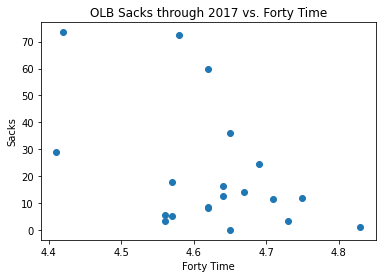

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
%matplotlib inline

# Plotting data for OLB 
plt.scatter(olb_data['Forty'], olb_data['Sacks'])
plt.xlabel('Forty Time')
plt.ylabel('Sacks')
plt.title('OLB Sacks through 2017 vs. Forty Time')
plt.show()

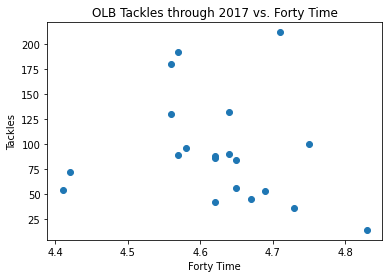

In [13]:
plt.scatter(olb_data['Forty'], olb_data['TotalTackles'])
plt.xlabel('Forty Time')
plt.ylabel('Tackles')
plt.title('OLB Tackles through 2017 vs. Forty Time')
plt.show()

For outside linebackers, there appears to be a negative linear relationship between total tackles and 40-yard dash time. There also seems to be the same relationship for sacks. More testing will be necessary in order to come to a stronger conclusion on the strength of these correlations.
# Defensive Backs:

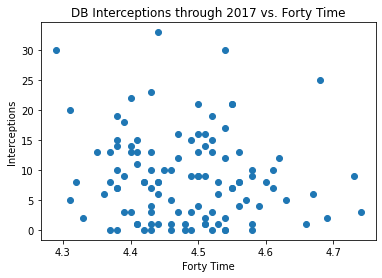

In [14]:
plt.scatter(db_data['Forty'], db_data['Ints'])
plt.xlabel('Forty Time')
plt.ylabel('Interceptions')
plt.title('DB Interceptions through 2017 vs. Forty Time')
plt.show()

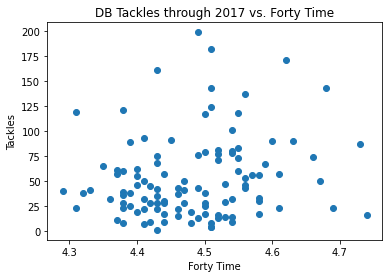

In [15]:
plt.scatter(db_data['Forty'], db_data['TotalTackles'])
plt.xlabel('Forty Time')
plt.ylabel('Tackles')
plt.title('DB Tackles through 2017 vs. Forty Time')
plt.show()

For both graphs, there does not appear to be a strong correlation between 40 time and any of these variables for defensive backs. However, the majority of tackles and interceptions appear to be attributed to those who recorded faster 40 times. To better represent this relationship, a bar graph will be used. The interceptions and tackles for the fastest third will be summed, then the same for the middle third and slowest third. 

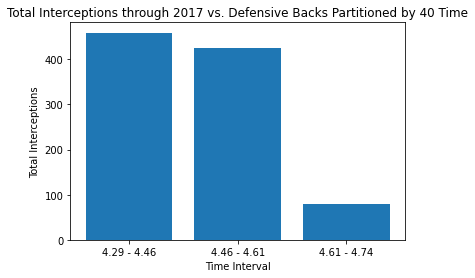

In [16]:
# Finding the third and two-thirds prospect's times in order to divide them up
db_third_mark = db_data.at[37, 'Forty']
db_two_thirds_mark = db_data.at[73, 'Forty']

# Summing interceptions from each third of prospects
ints1 = 0
ints2 = 0
ints3 = 0

for index, row in db_data.iterrows():
    if row['Forty'] <= db_third_mark:
        ints1 += row['Ints']
    elif row['Forty'] >= db_two_thirds_mark:
        ints3 += row['Ints']
    else: 
        ints2 += row['Ints']

intervals = ["4.29 - " + str(db_third_mark), str(db_third_mark) + " - " + str(db_two_thirds_mark), str(db_two_thirds_mark) + " - 4.74"]
summed_ints = [ints1, ints2, ints3]
total = ints1+ints2+ints3

plt.bar(intervals, summed_ints)
plt.title('Total Interceptions through 2017 vs. Defensive Backs Partitioned by 40 Time')
plt.xlabel('Time Interval')
plt.ylabel('Total Interceptions')
plt.show()

This graph clearly shows the value of a quick 40-yard dash time. 48% of total interceptions were recorded by the fastest third of the defensive backs and 92% of total interceptions were recorded by the fastest two-thirds of players, leaving the slowest third with only 8% to show for.

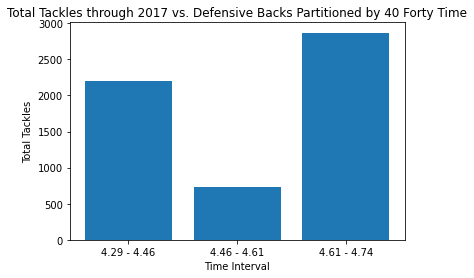

In [17]:
# Finding the third and two-thirds prospect's times in order to divide them up
db_data = db_data.sort_values(by = ['TotalTackles'], ascending = True)

db_third_mark = db_data.at[37, 'Forty']
db_two_thirds_mark = db_data.at[73, 'Forty']

# Summing interceptions from each third of prospects
tackles1 = 0
tackles2 = 0
tackles3 = 0

for index, row in db_data.iterrows():
    if row['Forty'] <= db_third_mark:
        tackles1 += row['TotalTackles']
    elif row['Forty'] >= db_two_thirds_mark:
        tackles2 += row['TotalTackles']
    else: 
        tackles3 += row['TotalTackles']

intervals = ["4.29 - " + str(db_third_mark), str(db_third_mark) + " - " + str(db_two_thirds_mark), str(db_two_thirds_mark) + " - 4.74"]
summed_ints = [tackles1, tackles2, tackles3]

plt.bar(intervals, summed_ints)
plt.title('Total Tackles through 2017 vs. Defensive Backs Partitioned by 40 Forty Time')
plt.xlabel('Time Interval')
plt.ylabel('Total Tackles')
plt.show()

Contrary to interceptions, the slowest third of players made the most tackles amongst defensive backs with 49% of the total. Strangely, the second largest total is the fastest third of players. When combined with the slowest third they account for 87% of the total. 

# Analyzing the Cone Drill
The cone drill involves prospects running between an assortment of cones while having to change direction and touch each one before they can move to the next. The ability to change direction is highly valued in the NFL and being able to maintain a high speed is even more rare. These factors combine to make the cone drill one of NFL organizations most considered events as they decide who to draft.
# Outside Linebackers:

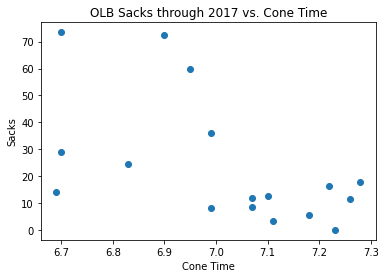

In [18]:
# Creating a dataframe exclusive to players who partipated in the cone drill
temp = pd.DataFrame(columns = ['Cone', 'Sacks', 'TotalTackles', 'GamesPlayed'])

for index, row in olb_data.iterrows():
    cone = row['Cone']
    sacks = row['Sacks']
    tackles = row['TotalTackles']
    gp = row['GamesPlayed']

    # Checking that cone time wasn't set to 0 
    if cone != 0:
        temp.loc[len(temp.index)] = [cone, sacks, tackles, gp]

plt.scatter(temp['Cone'], temp['Sacks'])
plt.xlabel('Cone Time')
plt.ylabel('Sacks')
plt.title('OLB Sacks through 2017 vs. Cone Time')
plt.show()

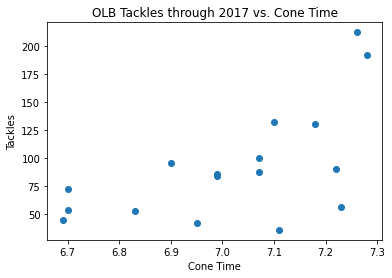

In [19]:
plt.scatter(temp['Cone'], temp['TotalTackles'])
plt.xlabel('Cone Time')
plt.ylabel('Tackles')
plt.title('OLB Tackles through 2017 vs. Cone Time')
plt.show()

There appears to be a slight negative correlation between sacks and cone time. This is logical as being fast and agile is key to get to the quarterback before he throws the ball. However, cone time and tackles appear to have a positive linear relationship which is interesting and requires further testing.

# Defensive Backs:

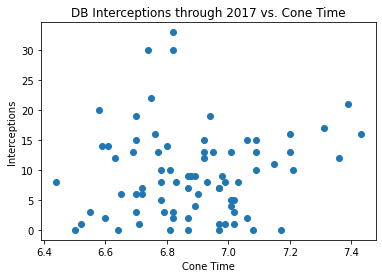

In [20]:
# Creating a dataframe exclusive to players who partipated in the cone drill
temp = pd.DataFrame(columns = ['Cone', 'Ints', 'TotalTackles', 'GamesPlayed'])

for index, row in db_data.iterrows():
    cone = row['Cone']
    ints = row['Ints']
    tackles = row['TotalTackles']
    gp = row['GamesPlayed']

    # Checking that cone time wasn't set to 0 
    if cone != 0:
        temp.loc[len(temp.index)] = [cone, ints, tackles, gp]

plt.scatter(temp['Cone'], temp['Ints'])
plt.xlabel('Cone Time')
plt.ylabel('Interceptions')
plt.title('DB Interceptions through 2017 vs. Cone Time')
plt.show()

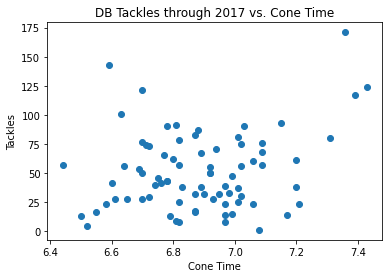

In [21]:
plt.scatter(temp['Cone'], temp['TotalTackles'])
plt.xlabel('Cone Time')
plt.ylabel('Tackles')
plt.title('DB Tackles through 2017 vs. Cone Time')
plt.show()

For defensive backs there seems to be a slight positive linear relationship between cone time and tackles, similar to outside linebackers. The other graph appears to be fairly uniform but the majority of interceptions appear to be made by players with quicker cone times. In order to better show this data, a bar graph will be used. The cone times will be divided into 3 sections containing the faster third of players, middle third, and slowest third. The bar will represent their summed interceptions.

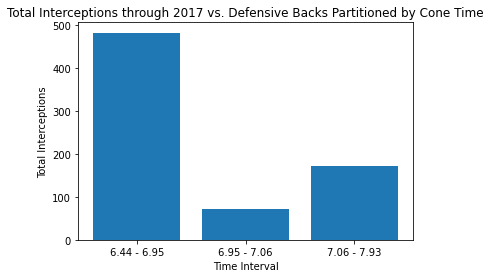

In [22]:
# Creating a dataframe for prospects with a cone time
copy = pd.DataFrame(columns = ['Cone', 'Ints'])
for index, row in db_data.iterrows():
    if row['Cone'] != 0:
            copy.loc[len(copy.index)] = [row['Cone'], row['Ints']]

# Finding the third and two-thirds prospect's times in order to divide them up
db_data = db_data.sort_values(by = ['Cone'], ascending = True)

db_third_mark = copy.at[26, 'Cone']
db_two_thirds_mark = copy.at[51, 'Cone']

# Summing interceptions from each third of prospects
ints1 = 0
ints2 = 0
ints3 = 0

for index, row in copy.iterrows():
    if row['Cone'] <= db_third_mark:
        ints1 += row['Ints']
    elif row['Cone'] >= db_two_thirds_mark:
        ints3 += row['Ints']
    else: 
        ints2 += row['Ints']

intervals = ["6.44 - " + str(db_third_mark), str(db_third_mark) + " - " + str(db_two_thirds_mark), str(db_two_thirds_mark) + " - 7.93"]
summed_ints = [ints1, ints2, ints3]

plt.bar(intervals, summed_ints)
plt.title('Total Interceptions through 2017 vs. Defensive Backs Partitioned by Cone Time')
plt.xlabel('Time Interval')
plt.ylabel('Total Interceptions')
plt.show()

After viewing the bar graph, it appears the interceptions are fairly distributed among each time interval. This is slightly strange given one would expect faster and more agile players to record more interceptions. 



# Predictions and Further Testing
Predicting a player's performance is nearly impossible as there are an uncountable amount of external factors that have nothing to do with a player's athleticism or skill. Team chemistry, coaching, and injuries can have dire impacts on a player's performance. On the other hand, sometimes players fit well into a particular team's system and thrive, despite their faults. Nevertheless, based on the data collected I am going to use linear regression to attempt to make a model to predict tackles and sacks based on 40-yard dash and cone time for outside linebackers. These correlations were chosen because their plots displayed some type of moderate linear correlation. For each graph, the correlation coefficient will be calculated to determine if the relationship is significant. As the name implies, the correlation coefficient is a value between 0 and 1 representing the strength of the relationship between two variables. A value of 0.9 or above is necessary to conclude a strong correlation. 
# Tackles vs. 40-Yard Dash

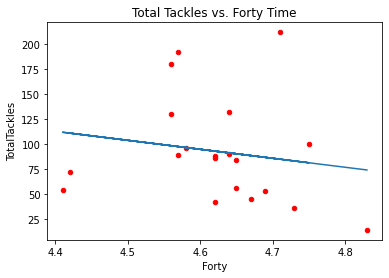

In [23]:
from sklearn.linear_model import LinearRegression

# Function that returns a linear regression model based on 2 variable parameters
def calculate_lin_reg(df, x, y):
    model = LinearRegression()
    X = [[x] for x in df[x].values]
    y = [[y] for y in df[y].values]
    model.fit(X, y)
    return model

model = calculate_lin_reg(olb_data, 'Forty', 'TotalTackles')

unique_times = [[x] for x in olb_data['Forty'].unique()]

ax = olb_data.plot('Forty', 'TotalTackles', kind = 'scatter', c = 'r')
ax.plot(unique_times, [y for [y] in model.predict(unique_times)])
plt.title('Total Tackles vs. Forty Time')
plt.show()

The line does not fit the data well. Calculating the correlation coefficient can confirm this conclusion.

In [35]:
import statsmodels.formula.api as smf

result = smf.ols(formula = 'TotalTackles ~ Forty', data = olb_data).fit()
print('Correlation Coefficient for Tackles vs. Forty: {}'.format(result.rsquared))

Correlation Coefficient for Tackles vs. Forty: 0.02830406929294782


# Sacks vs. 40-Yard Dash

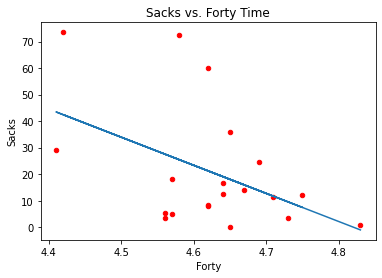

In [25]:
model = calculate_lin_reg(olb_data, 'Forty', 'Sacks')

unique_times = [[x] for x in olb_data['Forty'].unique()]

ax = olb_data.plot('Forty', 'Sacks', kind = 'scatter', c = 'r')
ax.plot(unique_times, [y for [y] in model.predict(unique_times)])
plt.title('Sacks vs. Forty Time')
plt.show()

This linear regression line is clearly more fitting than the previous but calculating the correlation coefficient is still necessary.

In [36]:
result = smf.ols(formula = 'Sacks ~ Forty', data = olb_data).fit()
print('Correlation Coefficient for Sacks vs. Forty: {}'.format(result.rsquared))

Correlation Coefficient for Sacks vs. Forty: 0.21535325556835483


# Tackles vs. Cone Drill

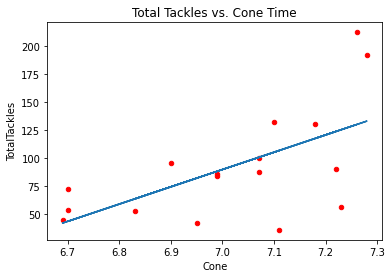

In [27]:
# Filtering the data into only those who have a cone time
copy = pd.DataFrame(columns = ['Cone', 'TotalTackles', 'Sacks'])
for index, row in olb_data.iterrows():
    if row['Cone'] != 0:
            copy.loc[len(copy.index)] = [row['Cone'], row['TotalTackles'], row['Sacks']]

model = calculate_lin_reg(copy, 'Cone', 'TotalTackles')

unique_times = [[x] for x in copy['Cone'].unique()]

ax = copy.plot('Cone', 'TotalTackles', kind = 'scatter', c = 'r')
ax.plot(unique_times, [y for [y] in model.predict(unique_times)])
plt.title('Total Tackles vs. Cone Time')
plt.show()

Contrary to expectation, the model has a positive correlation between cone time and tackles although there are significant residuals.  

In [37]:
result = smf.ols(formula = 'TotalTackles ~ Cone', data = copy).fit()
print('Correlation Coefficient for Tackles vs. Cone: {}'.format(result.rsquared))

Correlation Coefficient for Tackles vs. Cone: 0.3689226189056173


# Sacks vs. Cone Drill




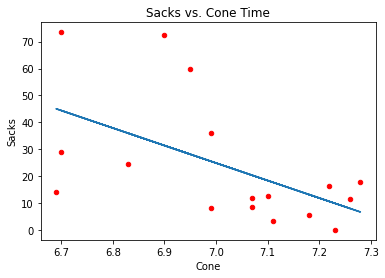

In [29]:
model = calculate_lin_reg(copy, 'Cone', 'Sacks')

unique_times = [[x] for x in copy['Cone'].unique()]

ax = copy.plot('Cone', 'Sacks', kind = 'scatter', c = 'r')
ax.plot(unique_times, [y for [y] in model.predict(unique_times)])
plt.title('Sacks vs. Cone Time')
plt.show()

There is clearly a negative linear correlation between two variables but the residuals are once again significant.



In [38]:
result = smf.ols(formula = 'Sacks ~ Cone', data = copy).fit()
print('Correlation Coefficient for Sacks vs. Cone: {}'.format(result.rsquared))

Correlation Coefficient for Sacks vs. Cone: 0.3031799814044741


Unfortunately, the correlation coefficients for all four relationships are not significant enough to declare any of the models as accurate. Nonetheless, it is still extremely interesting to observe the relationship between these variables. Most football fans would expect players with more impressive combine scores to produce more impressive statistics in the NFL but that clearly is not always the case. If the correlation coefficients had been greater than 0.9, the linear models could be used to estimate prospect's NFL success based on their combine times.



# Conclusion

Even though none of the correlations between combine metrics and NFL statistics are significant, there are still major points to be drawn from this series of tests. Namely, why isn't there a stronger relationship between the two? The combine seems to be one of the most influential forces in the draft yet there wasn't significant evidence supporting that an above average 40-yard dash or cone drill led to a prospect contributing more in the NFL. In the case of cone time and tackles for outside linebackers, a worse combine performance actually led to more tackles in the league.

Despite the correlations not being statistically significant, the majority of relationships between variables still followed expectations. One of the most powerful was found between 40-yard dash time and interceptions for defensive backs. 92% of interceptions coming from the fastest 67% of prospects clearly demonstrates the importance of a 40-yard dash time.

Intuitively, the more impressive a prospect performs at combine, the better he should play in the NFL. Being faster, stronger, or more agile than your opponents should be a distinct advantage that translates to a better statistical performance. Sadly, football isn't just a numbers game but that's exactly what makes it fun and beloved by fans. There will always be undrafted or late round players that become superstars just because football is so difficult to predict. Despite my failure to find a statistically significant correlation, I will still always look forward to the NFL combine and draft alike, along with the wave of emotions and surprises it entails.